# Le problème est : 

Quand on lance le processing pour NATL60, même si la région est petite (GS1), il est possible de processer uniquement un profil voire 0 avant de tomber sur un Processus Arrêté

In [1]:
reg='GS1'

In [2]:
## path for mdules
import sys
import warnings
warnings.filterwarnings('ignore')


## imports

import numpy as np
import dask
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import matplotlib.gridspec as gridspec
import time
from dask.diagnostics import ProgressBar
from datetime import date
import yaml
import io
import json
import os


In [3]:
def process(jsonfile,infos,prof,dsN,latN,lonN,timN,region,namezone):
        ''' Make all the steps needed to create the final netcdf files for one profile
        '''
        list_profiles = infos.keys()
        reference =  str(list(list_profiles)[prof])
        print('Processing profile ', reference)
        lat_prof = infos[list(list_profiles)[prof]]['latitude']
        lon_prof = infos[list(list_profiles)[prof]]['longitude']
        date_prof = infos[list(list_profiles)[prof]]['date']
        file_prof = infos[list(list_profiles)[prof]]['file']
        prof_prof = infos[list(list_profiles)[prof]]['profile no']

        check=check_prof_boundaries(dsN,latN,lonN,timN,lat_prof,lon_prof,date_prof)
        if check == 0.:
                profil_temp_model_mean,profil_temp_model_percent10,profil_temp_model_percent90,profil_salt_model_mean,profil_salt_model_percent10,profil_salt_model_percent90,observation_dep,obsred_temp,obsred_salt,dep_level,model_dep,obsred_dep,observation_lat,observation_lon,observation_time = model_mean_percent_profile(file_prof,prof_prof,dsN,latN,lonN,timN)
                create_netcdf_profile(jsonfile,reference,prof_prof,observation_lat,observation_lon,observation_time,profil_temp_model_mean,profil_temp_model_percent10,profil_temp_model_percent90,profil_salt_model_mean,profil_salt_model_percent10,profil_salt_model_percent90,observation_dep,obsred_temp,obsred_salt,dep_level,model_dep,obsred_dep,region,namezone)


In [4]:
def open_model(region):
        print('Opening data')
        tfiles="/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/1d/"+region+"/NATL60"+region+"-CJM165_y20??m??d??.1d_gridT.nc"

        dsN = xr.open_mfdataset(tfiles, decode_times=False, chunks={'deptht':1 ,'time_counter':10})

        latN = dsN.nav_lat
        lonN = dsN.nav_lon
        timN = dsN.time_counter
        return dsN,latN,lonN,timN


In [5]:
def check_prof_boundaries(dsN,latN,lonN,timN,lat_prof,lon_prof,date_prof):
        ''' Check if the selected profile falls within model boundaries
        '''

        lamin=np.nanmin(latN.values)
        lamax=np.nanmax(latN.values)
        lomin=np.nanmin(lonN.values)
        lomax=np.nanmax(lonN.values)

        if (lamin < lat_prof < lamax) & (lomin < lon_prof < lomax) :
                check=0.
                print("selected profile falls within model boundaries, the program is proceeding")
        else:
                check=1.
                print("selected profile does not fall within model boundaries, the program is stopping")
        distance_threshold = 0.25
        square_distance_to_observation = (lonN - lon_prof)**2 + (latN-lat_prof)**2
        is_close_to_observation = square_distance_to_observation < distance_threshold**2
        where_true=np.where(is_close_to_observation==True)
        if len(where_true[0]) < 1:
                check=1.
                print("there is no point in the model close enough to the profile, the program is stopping")
        else:
                check=0.
                print("there is a point in the model close enough to the profile, the program is proceeding")
        return check


In [6]:
def model_mean_percent_profile(fileEN4,ref_prof,dsN,latN,lonN,timN):
        #select NATL60 data at the closest depth and within 0.25 and 15days near the location and date of the ARGO profile
        diren4="/scratch/cnt0024/hmg2840/albert7a/EN4/"
        tfileEN4=diren4+fileEN4

        dsen4=xr.open_dataset(tfileEN4)

        laten4=dsen4['LATITUDE'][ref_prof]
        lonen4=dsen4['LONGITUDE'][ref_prof]
        dayen4=dsen4['JULD'][ref_prof]

        dateen4= pd.to_datetime(str(dayen4.values))
        ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
        tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()

        observation_lon=lonen4
        observation_lat=laten4
        observation_time=tsecen4

        tempen4=dsen4['POTM_CORRECTED'][ref_prof]
        salten4=dsen4['PSAL_CORRECTED'][ref_prof]
        depen4=dsen4['DEPH_CORRECTED'][ref_prof]

        observation_dep=depen4
        observation_temp=tempen4
        observation_salt=salten4

        depN = dsN.deptht
        tempN=dsN.votemper
        saltN=dsN.vosaline

        #get the number of useful levels in EN4 profile
        dep_level=np.zeros(1)
        for k in np.arange(len(observation_dep)):
                if not np.isnan(observation_dep[k]):
                        dep_level[0]=k

        #get the corresponding model level
        model_level=np.zeros(int(dep_level[0]))
        model_dep=np.zeros(int(dep_level[0]))
        obsred_dep=np.zeros(int(dep_level[0]))
        obsred_temp=np.zeros(int(dep_level[0]))
        obsred_salt=np.zeros(int(dep_level[0]))
        for z in np.arange(int(dep_level[0])):
                obsred_dep[int(z)]=observation_dep[int(z)]
                obsred_temp[int(z)]=observation_temp[int(z)]
                obsred_salt[int(z)]=observation_salt[int(z)]
                diff_dep=0*depN.values
                for k in np.arange(len(depN.values)):
                        diff_dep[k]=depN.values[k]-obsred_dep[int(z)]
                lev=np.where(np.abs(diff_dep)==np.min(np.abs(diff_dep)))
                model_level[z]=lev[0]
                model_dep[z]=depN.values[lev[0]]

        #Coarse box in which EN4 profile is contained
        step=1
        indxBOX=np.where((lonN>observation_lon-1)&(lonN<observation_lon+1)&(latN>observation_lat-1)&(latN<observation_lat+1))

        model_lonBOX=lonN[np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
        model_latBOX=latN[np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
        model_lonBOX_array=model_lonBOX.values
        model_latBOX_array=model_latBOX.values
        indtBOX=np.where((timN.values < tsecen4 + 15*24*3600) & (timN.values > tsecen4 - 15*24*3600) )
        model_tBOX=timN[indtBOX[0][0]:indtBOX[0][-1]]
        t_dim=np.arange(len(model_tBOX))
        x_dim=np.arange(model_lonBOX_array.shape[1])
        y_dim=np.arange(model_lonBOX_array.shape[0])

        def profile_mean_percent(k):

                #decoupage grossier autour de la position du profile ARGO pour un niveau vertical

                model_tempBOX=tempN[indtBOX[0][0]:indtBOX[0][-1],k,np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
                model_saltBOX=saltN[indtBOX[0][0]:indtBOX[0][-1],k,np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]

                model_tempBOX_array=model_tempBOX.values
                model_saltBOX_array=model_saltBOX.values
                model_tBOX_array=model_tBOX.values

                # construction d'un nouveau xarray
                d = {}
                d['time_counter'] = ('time_counter',t_dim)
                d['y'] = ('y',y_dim)
                d['x'] = ('x',x_dim)
                d['nav_lat'] = (['y','x'],model_latBOX_array)
                d['nav_lon'] = (['y','x'],model_lonBOX_array)

                d['votemper'] = (['time_counter','y','x'], model_tempBOX_array)
                d['vosaline'] = (['time_counter','y','x'], model_saltBOX_array)
                d['time_counter'] = (['time_counter'], model_tBOX_array)
                dset = xr.Dataset(d)

                latB = dset.nav_lat
                lonB = dset.nav_lon
                model_temperatureB = dset.votemper
                model_salinityB = dset.vosaline
                model_timeB = dset.time_counter

                # selection plus fine des profils

                lon_stacked = lonB.stack(profile=('x', 'y'))
                lat_stacked = latB.stack(profile=('x', 'y'))

                distance_threshold = 0.25
                square_distance_to_observation = (lon_stacked - observation_lon)**2 + (lat_stacked-observation_lat)**2
                is_close_to_observation = square_distance_to_observation < distance_threshold**2

                model_temperature_stacked = model_temperatureB.stack(profile=('x', 'y'))
                model_salinity_stacked = model_salinityB.stack(profile=('x', 'y'))

                model_temperature_near_observation = model_temperature_stacked.where(is_close_to_observation,drop=True)
                model_salinity_near_observation = model_salinity_stacked.where(is_close_to_observation, drop=True)
                lat_near_observation = lat_stacked.where(is_close_to_observation, drop=True)
                lon_near_observation = lon_stacked.where(is_close_to_observation, drop=True)

                model_temp_dask=dask.array.from_array(model_temperature_near_observation,chunks=(100,100))
                model_temp_dask_concat=dask.array.concatenate(model_temp_dask)
                model_salt_dask=dask.array.from_array(model_salinity_near_observation,chunks=(100,100))
                model_salt_dask_concat=dask.array.concatenate(model_salt_dask)
                temp_model_mean = model_temp_dask_concat.mean().compute()
                temp_percentile_10= np.percentile(model_temp_dask_concat,10)
                temp_percentile_90= np.percentile(model_temp_dask_concat,90)
                salt_model_mean = model_salt_dask_concat.mean().compute()
                salt_percentile_10= np.percentile(model_salt_dask_concat,10)
                salt_percentile_90= np.percentile(model_salt_dask_concat,90)

                return lat_near_observation,lon_near_observation,temp_model_mean,temp_percentile_10,temp_percentile_90,salt_model_mean,salt_percentile_10,salt_percentile_90

        profil_temp_model_mean=np.zeros(int(dep_level[0]))
        profil_temp_model_percent10=np.zeros(int(dep_level[0]))
        profil_temp_model_percent90=np.zeros(int(dep_level[0]))
        profil_salt_model_mean=np.zeros(int(dep_level[0]))
        profil_salt_model_percent10=np.zeros(int(dep_level[0]))
        profil_salt_model_percent90=np.zeros(int(dep_level[0]))


        for z in np.arange(dep_level[0]):
                lat_near_observation,lon_near_observation,temp_model_mean,temp_percentile_10,temp_percentile_90,salt_model_mean,salt_percentile_10,salt_percentile_90=profile_mean_percent(int(model_level[int(z)]))
                profil_temp_model_mean[int(z)]=temp_model_mean
                profil_temp_model_percent10[int(z)]=temp_percentile_10
                profil_temp_model_percent90[int(z)]=temp_percentile_90
                profil_salt_model_mean[int(z)]=salt_model_mean
                profil_salt_model_percent10[int(z)]=salt_percentile_10
                profil_salt_model_percent90[int(z)]=salt_percentile_90

        return profil_temp_model_mean,profil_temp_model_percent10,profil_temp_model_percent90,profil_salt_model_mean,profil_salt_model_percent10,profil_salt_model_percent90,observation_dep,obsred_temp,obsred_salt,dep_level,model_dep,obsred_dep,observation_lat,observation_lon,observation_time


In [7]:
def create_netcdf_profile(jsonfile,reference,ref_prof,observation_lat,observation_lon,observation_time,profil_temp_model_mean,profil_temp_model_percent10,profil_temp_model_percent90,profil_salt_model_mean,profil_salt_model_percent10,profil_salt_model_percent90,observation_dep,obsred_temp,obsred_salt,dep_level,model_dep,obsred_dep,region,namezone):

        reference_profile=reference[-16:-1]
        dirname="/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/"+namezone+"/NATL60-CJM165/"+region
        if not os.path.exists(dirname):
                os.mkdir(dirname)

        outname="/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/"+namezone+"/NATL60-CJM165/"+region+"/profiles_EN4-"+reference_profile+"_NATL60-CJM165_TS.nc"
        print('output file is '+outname)
        dsout=Dataset(outname,'w')

        today=date.today()
        dsout.description = "This file contains one profile of temperature and salinity from EN4 dataset and the mean and 10 and 90 percentile of NATL60-CJM165 data within a 0.25deg circle around the location of the profile and 15 days before and after it has been sampled. This file has been created "+str(today.day)+"/"+str(today.month)+"/"+str(today.year)

        depth=dsout.createDimension('depth',dep_level[0])
        x=dsout.createDimension('x',1)
        y=dsout.createDimension('y',1)
        lat = dsout.createVariable('latitude_profileEN4', 'f8', ('y','x'))
        lat.standart_name="latitude_profileEN4"
        lat.long_name = "Latitude of selected EN4 profile"
        lat.units = "degrees_north"

        lon = dsout.createVariable('longitude_profileEN4', 'f8', ('y','x'))
        lon.standart_name="longitude_profileEN4"
        lon.long_name = "Longitude of selected EN4 profile"
        lon.units = "degrees_east"
        time = dsout.createVariable('time_profileEN4', 'f8', ('y','x'))
        time.standart_name="time_profileEN4"
        time.timeg_name = "Time in seconds from 1-1-1958 of selected EN4 profile"
        time.units = "seconds"

        depth_en4 = dsout.createVariable('depth_en4', 'f8', ('depth'),fill_value=0.)
        depth_en4.units = "m"
        depth_en4.valid_min = 0.
        depth_en4.valid_max = 8000.
        depth_en4.long_name = "Depth"

        depth_model = dsout.createVariable('depth_model', 'f8', ('depth'),fill_value=0.)
        depth_model.units = "m"
        depth_model.valid_min = 0.
        depth_model.valid_max = 8000.
        depth_model.long_name = "Depth"

        temp_en4 = dsout.createVariable('temp_profileEN4', 'f8', ('depth'),fill_value=0.)
        temp_en4.units = "degC"
        temp_en4.valid_min = -10.
        temp_en4.valid_max = 40.
        temp_en4.long_name = "Temperature profile of the selected EN4 profile"

        salt_en4 = dsout.createVariable('salt_profileEN4', 'f8', ('depth'),fill_value=0.)
        salt_en4.units = "PSU"
        salt_en4.valid_min = 20.
        salt_en4.valid_max = 40.
        salt_en4.long_name = "Salinity profile of the selected EN4 profile"

        mean_temp_model = dsout.createVariable('mean_temp_model', 'f8', ('depth'),fill_value=0.)
        mean_temp_model.units = "degC"
        mean_temp_model.valid_min = -10.
        mean_temp_model.valid_max = 40.
        mean_temp_model.long_name = "Mean Temperature profile of the model"

        mean_salt_model = dsout.createVariable('mean_salt_model', 'f8', ('depth'),fill_value=0.)
        mean_salt_model.units = "PSU"
        mean_salt_model.valid_min = 20.
        mean_salt_model.valid_max = 40.
        mean_salt_model.long_name = "Mean Salinity profile of the model"

        percent10_temp_model = dsout.createVariable('percent10_temp_model', 'f8', ('depth'),fill_value=0.)
        percent10_temp_model.units = "degC"
        percent10_temp_model.valid_min = -10.
        percent10_temp_model.valid_max = 40.
        percent10_temp_model.long_name = "Percent 10 Temperature profile of the model"

        percent10_salt_model = dsout.createVariable('percent10_salt_model', 'f8', ('depth'),fill_value=0.)
        percent10_salt_model.units = "PSU"
        percent10_salt_model.valid_min = 20.
        percent10_salt_model.valid_max = 40.
        percent10_salt_model.long_name = "Percent 10 Salinity profile of the model"

        percent90_temp_model = dsout.createVariable('percent90_temp_model', 'f8', ('depth'),fill_value=0.)
        percent90_temp_model.units = "degC"
        percent90_temp_model.valid_min = -90.
        percent90_temp_model.valid_max = 40.
        percent90_temp_model.long_name = "Percent 90 Temperature profile of the model"

        percent90_salt_model = dsout.createVariable('percent90_salt_model', 'f8', ('depth'),fill_value=0.)
        percent90_salt_model.units = "PSU"
        percent90_salt_model.valid_min = 20.
        percent90_salt_model.valid_max = 40.
        percent90_salt_model.long_name = "Percent 90 Salinity profile of the model"


        lat[:]=observation_lat
        lon[:]=observation_lon
        time[:]=observation_time
        depth_en4[:]=obsred_dep
        depth_model[:]=model_dep
        temp_en4[:]=obsred_temp
        salt_en4[:]=obsred_salt
        mean_temp_model[:]=profil_temp_model_mean
        mean_salt_model[:]=profil_salt_model_mean
        percent10_temp_model[:]=profil_temp_model_percent10
        percent10_salt_model[:]=profil_salt_model_percent10
        percent90_temp_model[:]=profil_temp_model_percent90
        percent90_salt_model[:]=profil_salt_model_percent90
        dsout.close()  # close the new file


In [8]:
        jsonfile = '/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/NATL60-CJM165_GS_y2012-2013_final.json'
        dirn = '/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/NATL60-CJM165/GS/'
        region = 'GS1'
        namezone = 'NATL60-CJM165_GS_y2012-2013'

        sourcefile=open(jsonfile,'rU')
        infos=json.load(sourcefile)
        nb_profilesEN4=len(infos)

        print(time.strftime('%d/%m/%y %H:%M',time.localtime()))
        dsN,latN,lonN,timN = open_model(region)
        print(time.strftime('%d/%m/%y %H:%M',time.localtime()))



13/02/20 14:30
Opening data
13/02/20 14:32


In [ ]:
        for prof in np.arange(nb_profilesEN4):
                print(prof)
                list_profiles = infos.keys()
                reference = str(list(list_profiles)[prof])
                reference_profile=reference[-16:-1]
                print("dealing with profile "+reference_profile)
                outname=dirn+"/profiles_EN4-"+reference_profile+"_NATL60-CJM165_TS.nc"

                if not os.path.exists(outname):
                        print(outname+" does not exist; lets process")
                        process(jsonfile,infos,prof,dsN,latN,lonN,timN,region,namezone)
                else:
                        print(outname+" already exists")


0
dealing with profile A20121001-03173
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/NATL60-CJM165/GS//profiles_EN4-A20121001-03173_NATL60-CJM165_TS.nc already exists
1
dealing with profile A20121001-03175
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/NATL60-CJM165/GS//profiles_EN4-A20121001-03175_NATL60-CJM165_TS.nc already exists
2
dealing with profile A20121001-03182
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/NATL60-CJM165/GS//profiles_EN4-A20121001-03182_NATL60-CJM165_TS.nc already exists
3
dealing with profile A20121001-03196
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/NATL60-CJM165/GS//profiles_EN4-A20121001-03196_NATL60-CJM165_TS.nc does not exist; lets process
Processing profile  b' A20121001-03196'
selected profile does not fall within model boundaries, the program is stopping
there is no point in the model close enough to the profile

In [9]:
import gc

In [10]:
prof=6

In [11]:
count=gc.get_count()
print('avant'+str(count))


avant(123, 8, 231)


In [12]:
                count=gc.get_count()
                print('avant'+str(count))
                print(prof)
                list_profiles = infos.keys()
                reference = str(list(list_profiles)[prof])
                reference_profile=reference[-16:-1]
                print("dealing with profile "+reference_profile)
                outname=dirn+"/profiles_EN4-"+reference_profile+"_NATL60-CJM165_TS.nc"
                print(outname+" does not exist; lets process")
                        

avant(243, 8, 231)
6
dealing with profile A20121001-03208
/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_GS_y2012-2013/NATL60-CJM165/GS//profiles_EN4-A20121001-03208_NATL60-CJM165_TS.nc does not exist; lets process


In [13]:
        list_profiles = infos.keys()
        reference =  str(list(list_profiles)[prof])
        print('Processing profile ', reference)
        lat_prof = infos[list(list_profiles)[prof]]['latitude']
        lon_prof = infos[list(list_profiles)[prof]]['longitude']
        date_prof = infos[list(list_profiles)[prof]]['date']
        file_prof = infos[list(list_profiles)[prof]]['file']
        prof_prof = infos[list(list_profiles)[prof]]['profile no']

        check=check_prof_boundaries(dsN,latN,lonN,timN,lat_prof,lon_prof,date_prof)


Processing profile  b' A20121001-03208'
selected profile does not fall within model boundaries, the program is stopping
there is a point in the model close enough to the profile, the program is proceeding


In [14]:
                count=gc.get_count()
                print('apres check boundaries '+str(count))


apres check boundaries (55, 5, 252)


In [ ]:
        fileEN4,ref_prof,dsN,latN,lonN,timN = file_prof,prof_prof,dsN,latN,lonN,timN
        
        diren4="/scratch/cnt0024/hmg2840/albert7a/EN4/"
        tfileEN4=diren4+fileEN4

        dsen4=xr.open_dataset(tfileEN4)

        laten4=dsen4['LATITUDE'][ref_prof]
        lonen4=dsen4['LONGITUDE'][ref_prof]
        dayen4=dsen4['JULD'][ref_prof]

        dateen4= pd.to_datetime(str(dayen4.values))
        ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
        tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()

        observation_lon=lonen4
        observation_lat=laten4
        observation_time=tsecen4

        tempen4=dsen4['POTM_CORRECTED'][ref_prof]
        salten4=dsen4['PSAL_CORRECTED'][ref_prof]
        depen4=dsen4['DEPH_CORRECTED'][ref_prof]

        observation_dep=depen4
        observation_temp=tempen4
        observation_salt=salten4

        depN = dsN.deptht
        tempN=dsN.votemper
        saltN=dsN.vosaline
        
        print('lecture des profils ok')

        #get the number of useful levels in EN4 profile
        dep_level=np.zeros(1)
        for k in np.arange(len(observation_dep)):
                if not np.isnan(observation_dep[k]):
                        dep_level[0]=k

        #get the corresponding model level
        model_level=np.zeros(int(dep_level[0]))
        model_dep=np.zeros(int(dep_level[0]))
        obsred_dep=np.zeros(int(dep_level[0]))
        obsred_temp=np.zeros(int(dep_level[0]))
        obsred_salt=np.zeros(int(dep_level[0]))
        for z in np.arange(int(dep_level[0])):
                obsred_dep[int(z)]=observation_dep[int(z)]
                obsred_temp[int(z)]=observation_temp[int(z)]
                obsred_salt[int(z)]=observation_salt[int(z)]
                diff_dep=0*depN.values
                for k in np.arange(len(depN.values)):
                        diff_dep[k]=depN.values[k]-obsred_dep[int(z)]
                lev=np.where(np.abs(diff_dep)==np.min(np.abs(diff_dep)))
                model_level[z]=lev[0]
                model_dep[z]=depN.values[lev[0]]

        print('find model depth ok')

        #Coarse box in which EN4 profile is contained
        step=1
        indxBOX=np.where((lonN>observation_lon-1)&(lonN<observation_lon+1)&(latN>observation_lat-1)&(latN<observation_lat+1))

        model_lonBOX=lonN[np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
        model_latBOX=latN[np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
        model_lonBOX_array=model_lonBOX.values
        model_latBOX_array=model_latBOX.values
        indtBOX=np.where((timN.values < tsecen4 + 15*24*3600) & (timN.values > tsecen4 - 15*24*3600) )
        model_tBOX=timN[indtBOX[0][0]:indtBOX[0][-1]]
        t_dim=np.arange(len(model_tBOX))
        x_dim=np.arange(model_lonBOX_array.shape[1])
        y_dim=np.arange(model_lonBOX_array.shape[0])

        print('coarse box ok')

        def profile_mean_percent(k):
                print('debut profile mean percent')

                #decoupage grossier autour de la position du profile ARGO pour un niveau vertical

                model_tempBOX=tempN[indtBOX[0][0]:indtBOX[0][-1],k,np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
                model_saltBOX=saltN[indtBOX[0][0]:indtBOX[0][-1],k,np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]

                model_tempBOX_array=model_tempBOX.values
                model_saltBOX_array=model_saltBOX.values
                model_tBOX_array=model_tBOX.values

                print('coarse temp and salt ok')

                # construction d'un nouveau xarray
                d = {}
                d['time_counter'] = ('time_counter',t_dim)
                d['y'] = ('y',y_dim)
                d['x'] = ('x',x_dim)
                d['nav_lat'] = (['y','x'],model_latBOX_array)
                d['nav_lon'] = (['y','x'],model_lonBOX_array)

                d['votemper'] = (['time_counter','y','x'], model_tempBOX_array)
                d['vosaline'] = (['time_counter','y','x'], model_saltBOX_array)
                d['time_counter'] = (['time_counter'], model_tBOX_array)
                dset = xr.Dataset(d)

                latB = dset.nav_lat
                lonB = dset.nav_lon
                model_temperatureB = dset.votemper
                model_salinityB = dset.vosaline
                model_timeB = dset.time_counter

                print('new array ok')
                # selection plus fine des profils

                lon_stacked = lonB.stack(profile=('x', 'y'))
                lat_stacked = latB.stack(profile=('x', 'y'))

                distance_threshold = 0.25
                square_distance_to_observation = (lon_stacked - observation_lon)**2 + (lat_stacked-observation_lat)**2
                is_close_to_observation = square_distance_to_observation < distance_threshold**2

                model_temperature_stacked = model_temperatureB.stack(profile=('x', 'y'))
                model_salinity_stacked = model_salinityB.stack(profile=('x', 'y'))

                print('stack ok')
                model_temperature_near_observation = model_temperature_stacked.where(is_close_to_observation,drop=True)
                model_salinity_near_observation = model_salinity_stacked.where(is_close_to_observation, drop=True)
                lat_near_observation = lat_stacked.where(is_close_to_observation, drop=True)
                lon_near_observation = lon_stacked.where(is_close_to_observation, drop=True)
                print('near obs ok')

                model_temp_dask=dask.array.from_array(model_temperature_near_observation,chunks=(100,100))
                model_temp_dask_concat=dask.array.concatenate(model_temp_dask)
                model_salt_dask=dask.array.from_array(model_salinity_near_observation,chunks=(100,100))
                model_salt_dask_concat=dask.array.concatenate(model_salt_dask)
                temp_model_mean = model_temp_dask_concat.mean().compute()
                temp_percentile_10= np.percentile(model_temp_dask_concat,10)
                temp_percentile_90= np.percentile(model_temp_dask_concat,90)
                salt_model_mean = model_salt_dask_concat.mean().compute()
                salt_percentile_10= np.percentile(model_salt_dask_concat,10)
                salt_percentile_90= np.percentile(model_salt_dask_concat,90)
                print('profile mean percent ok')

                return lat_near_observation,lon_near_observation,temp_model_mean,temp_percentile_10,temp_percentile_90,salt_model_mean,salt_percentile_10,salt_percentile_90

        profil_temp_model_mean=np.zeros(int(dep_level[0]))
        profil_temp_model_percent10=np.zeros(int(dep_level[0]))
        profil_temp_model_percent90=np.zeros(int(dep_level[0]))
        profil_salt_model_mean=np.zeros(int(dep_level[0]))
        profil_salt_model_percent10=np.zeros(int(dep_level[0]))
        profil_salt_model_percent90=np.zeros(int(dep_level[0]))


        for z in np.arange(dep_level[0]):
                print('profile mean percent debut level',z)
                lat_near_observation,lon_near_observation,temp_model_mean,temp_percentile_10,temp_percentile_90,salt_model_mean,salt_percentile_10,salt_percentile_90=profile_mean_percent(int(model_level[int(z)]))
                profil_temp_model_mean[int(z)]=temp_model_mean
                profil_temp_model_percent10[int(z)]=temp_percentile_10
                profil_temp_model_percent90[int(z)]=temp_percentile_90
                profil_salt_model_mean[int(z)]=salt_model_mean
                profil_salt_model_percent10[int(z)]=salt_percentile_10
                profil_salt_model_percent90[int(z)]=salt_percentile_90
                print('profile mean percent fin level',z)



lecture des profils ok
find model depth ok
coarse box ok
profile mean percent debut level 0.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 0.0
profile mean percent debut level 1.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 1.0
profile mean percent debut level 2.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 2.0
profile mean percent debut level 3.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 3.0
profile mean percent debut level 4.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 4.0
profile mean percent debut level 5.0
d

coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 45.0
profile mean percent debut level 46.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 46.0
profile mean percent debut level 47.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 47.0
profile mean percent debut level 48.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 48.0
profile mean percent debut level 49.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 49.0
profile mean percent debut level 50.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
pro

coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 90.0
profile mean percent debut level 91.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 91.0
profile mean percent debut level 92.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 92.0
profile mean percent debut level 93.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 93.0
profile mean percent debut level 94.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 94.0
profile mean percent debut level 95.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
pro

coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 135.0
profile mean percent debut level 136.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 136.0
profile mean percent debut level 137.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 137.0
profile mean percent debut level 138.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 138.0
profile mean percent debut level 139.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 139.0
profile mean percent debut level 140.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean perc

coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 180.0
profile mean percent debut level 181.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 181.0
profile mean percent debut level 182.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 182.0
profile mean percent debut level 183.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 183.0
profile mean percent debut level 184.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 184.0
profile mean percent debut level 185.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean perc

coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 225.0
profile mean percent debut level 226.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 226.0
profile mean percent debut level 227.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 227.0
profile mean percent debut level 228.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 228.0
profile mean percent debut level 229.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 229.0
profile mean percent debut level 230.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean perc

coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 270.0
profile mean percent debut level 271.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 271.0
profile mean percent debut level 272.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 272.0
profile mean percent debut level 273.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 273.0
profile mean percent debut level 274.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 274.0
profile mean percent debut level 275.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean perc

coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 315.0
profile mean percent debut level 316.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 316.0
profile mean percent debut level 317.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 317.0
profile mean percent debut level 318.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 318.0
profile mean percent debut level 319.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 319.0
profile mean percent debut level 320.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean perc

coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 360.0
profile mean percent debut level 361.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 361.0
profile mean percent debut level 362.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 362.0
profile mean percent debut level 363.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 363.0
profile mean percent debut level 364.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean percent ok
profile mean percent fin level 364.0
profile mean percent debut level 365.0
debut profile mean percent
coarse temp and salt ok
new array ok
stack ok
near obs ok
profile mean perc

In [ ]:
        fileEN4,ref_prof,dsN,latN,lonN,timN = file_prof,prof_prof,dsN,latN,lonN,timN
        
        diren4="/scratch/cnt0024/hmg2840/albert7a/EN4/"
        tfileEN4=diren4+fileEN4

        dsen4=xr.open_dataset(tfileEN4)

        laten4=dsen4['LATITUDE'][ref_prof]
        lonen4=dsen4['LONGITUDE'][ref_prof]
        dayen4=dsen4['JULD'][ref_prof]

        dateen4= pd.to_datetime(str(dayen4.values))
        ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
        tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()

        observation_lon=lonen4
        observation_lat=laten4
        observation_time=tsecen4

        tempen4=dsen4['POTM_CORRECTED'][ref_prof]
        salten4=dsen4['PSAL_CORRECTED'][ref_prof]
        depen4=dsen4['DEPH_CORRECTED'][ref_prof]

        observation_dep=depen4
        observation_temp=tempen4
        observation_salt=salten4

        depN = dsN.deptht
        tempN=dsN.votemper
        saltN=dsN.vosaline
        
        #get the number of useful levels in EN4 profile
        dep_level=np.zeros(1)
        for k in np.arange(len(observation_dep)):
                if not np.isnan(observation_dep[k]):
                        dep_level[0]=k

        #get the corresponding model level
        model_level=np.zeros(int(dep_level[0]))
        model_dep=np.zeros(int(dep_level[0]))
        obsred_dep=np.zeros(int(dep_level[0]))
        obsred_temp=np.zeros(int(dep_level[0]))
        obsred_salt=np.zeros(int(dep_level[0]))
        for z in np.arange(int(dep_level[0])):
                obsred_dep[int(z)]=observation_dep[int(z)]
                obsred_temp[int(z)]=observation_temp[int(z)]
                obsred_salt[int(z)]=observation_salt[int(z)]
                diff_dep=0*depN.values
                for k in np.arange(len(depN.values)):
                        diff_dep[k]=depN.values[k]-obsred_dep[int(z)]
                lev=np.where(np.abs(diff_dep)==np.min(np.abs(diff_dep)))
                model_level[z]=lev[0]
                model_dep[z]=depN.values[lev[0]]


        #Coarse box in which EN4 profile is contained
        step=1
        indxBOX=np.where((lonN>observation_lon-1)&(lonN<observation_lon+1)&(latN>observation_lat-1)&(latN<observation_lat+1))

        model_lonBOX=lonN[np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
        model_latBOX=latN[np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
        model_lonBOX_array=model_lonBOX.values
        model_latBOX_array=model_latBOX.values
        indtBOX=np.where((timN.values < tsecen4 + 15*24*3600) & (timN.values > tsecen4 - 15*24*3600) )
        model_tBOX=timN[indtBOX[0][0]:indtBOX[0][-1]]
        t_dim=np.arange(len(model_tBOX))
        x_dim=np.arange(model_lonBOX_array.shape[1])
        y_dim=np.arange(model_lonBOX_array.shape[0])


        def profile_mean_percent(k):

                #decoupage grossier autour de la position du profile ARGO pour un niveau vertical

                model_tempBOX=tempN[indtBOX[0][0]:indtBOX[0][-1],k,np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]
                model_saltBOX=saltN[indtBOX[0][0]:indtBOX[0][-1],k,np.min(indxBOX[0]):np.max(indxBOX[0]):step,np.min(indxBOX[1]):np.max(indxBOX[1]):step]

                model_tempBOX_array=model_tempBOX.values
                model_saltBOX_array=model_saltBOX.values
                model_tBOX_array=model_tBOX.values


                # construction d'un nouveau xarray
                d = {}
                d['time_counter'] = ('time_counter',t_dim)
                d['y'] = ('y',y_dim)
                d['x'] = ('x',x_dim)
                d['nav_lat'] = (['y','x'],model_latBOX_array)
                d['nav_lon'] = (['y','x'],model_lonBOX_array)

                d['votemper'] = (['time_counter','y','x'], model_tempBOX_array)
                d['vosaline'] = (['time_counter','y','x'], model_saltBOX_array)
                d['time_counter'] = (['time_counter'], model_tBOX_array)
                dset = xr.Dataset(d)

                latB = dset.nav_lat
                lonB = dset.nav_lon
                model_temperatureB = dset.votemper
                model_salinityB = dset.vosaline
                model_timeB = dset.time_counter

                # selection plus fine des profils

                lon_stacked = lonB.stack(profile=('x', 'y'))
                lat_stacked = latB.stack(profile=('x', 'y'))

                distance_threshold = 0.25
                square_distance_to_observation = (lon_stacked - observation_lon)**2 + (lat_stacked-observation_lat)**2
                is_close_to_observation = square_distance_to_observation < distance_threshold**2

                model_temperature_stacked = model_temperatureB.stack(profile=('x', 'y'))
                model_salinity_stacked = model_salinityB.stack(profile=('x', 'y'))

                model_temperature_near_observation = model_temperature_stacked.where(is_close_to_observation,drop=True)
                model_salinity_near_observation = model_salinity_stacked.where(is_close_to_observation, drop=True)
                lat_near_observation = lat_stacked.where(is_close_to_observation, drop=True)
                lon_near_observation = lon_stacked.where(is_close_to_observation, drop=True)

                model_temp_dask=dask.array.from_array(model_temperature_near_observation,chunks=(100,100))
                model_temp_dask_concat=dask.array.concatenate(model_temp_dask)
                model_salt_dask=dask.array.from_array(model_salinity_near_observation,chunks=(100,100))
                model_salt_dask_concat=dask.array.concatenate(model_salt_dask)
                temp_model_mean = model_temp_dask_concat.mean().compute()
                temp_percentile_10= np.percentile(model_temp_dask_concat,10)
                temp_percentile_90= np.percentile(model_temp_dask_concat,90)
                salt_model_mean = model_salt_dask_concat.mean().compute()
                salt_percentile_10= np.percentile(model_salt_dask_concat,10)
                salt_percentile_90= np.percentile(model_salt_dask_concat,90)

                return lat_near_observation,lon_near_observation,temp_model_mean,temp_percentile_10,temp_percentile_90,salt_model_mean,salt_percentile_10,salt_percentile_90

        profil_temp_model_mean=np.zeros(int(dep_level[0]))
        profil_temp_model_percent10=np.zeros(int(dep_level[0]))
        profil_temp_model_percent90=np.zeros(int(dep_level[0]))
        profil_salt_model_mean=np.zeros(int(dep_level[0]))
        profil_salt_model_percent10=np.zeros(int(dep_level[0]))
        profil_salt_model_percent90=np.zeros(int(dep_level[0]))


        for z in np.arange(dep_level[0]):
                count=gc.get_count()
                print('debut profile mean lev '+str(z)+' gc = '+str(count))
                lat_near_observation,lon_near_observation,temp_model_mean,temp_percentile_10,temp_percentile_90,salt_model_mean,salt_percentile_10,salt_percentile_90=profile_mean_percent(int(model_level[int(z)]))
                profil_temp_model_mean[int(z)]=temp_model_mean
                profil_temp_model_percent10[int(z)]=temp_percentile_10
                profil_temp_model_percent90[int(z)]=temp_percentile_90
                profil_salt_model_mean[int(z)]=salt_model_mean
                profil_salt_model_percent10[int(z)]=salt_percentile_10
                profil_salt_model_percent90[int(z)]=salt_percentile_90
                print('fin profile mean lev '+str(z)+' gc = '+str(count))
 


debut profile mean lev 0.0 gc = (78, 1, 12)
fin profile mean lev 0.0 gc = (78, 1, 12)
debut profile mean lev 1.0 gc = (8, 10, 12)
fin profile mean lev 1.0 gc = (8, 10, 12)
debut profile mean lev 2.0 gc = (8, 6, 13)
fin profile mean lev 2.0 gc = (8, 6, 13)
debut profile mean lev 3.0 gc = (8, 1, 14)
fin profile mean lev 3.0 gc = (8, 1, 14)
debut profile mean lev 4.0 gc = (8, 8, 14)
fin profile mean lev 4.0 gc = (8, 8, 14)
debut profile mean lev 5.0 gc = (8, 3, 15)
fin profile mean lev 5.0 gc = (8, 3, 15)
debut profile mean lev 6.0 gc = (8, 10, 15)
fin profile mean lev 6.0 gc = (8, 10, 15)
debut profile mean lev 7.0 gc = (8, 5, 16)
fin profile mean lev 7.0 gc = (8, 5, 16)
debut profile mean lev 8.0 gc = (8, 0, 17)
fin profile mean lev 8.0 gc = (8, 0, 17)
debut profile mean lev 9.0 gc = (8, 7, 17)
fin profile mean lev 9.0 gc = (8, 7, 17)
debut profile mean lev 10.0 gc = (8, 2, 18)
fin profile mean lev 10.0 gc = (8, 2, 18)
debut profile mean lev 11.0 gc = (8, 9, 18)
fin profile mean lev 11.

fin profile mean lev 95.0 gc = (8, 9, 67)
debut profile mean lev 96.0 gc = (8, 4, 68)
fin profile mean lev 96.0 gc = (8, 4, 68)
debut profile mean lev 97.0 gc = (8, 11, 68)
fin profile mean lev 97.0 gc = (8, 11, 68)
debut profile mean lev 98.0 gc = (1, 6, 69)
fin profile mean lev 98.0 gc = (1, 6, 69)
debut profile mean lev 99.0 gc = (8, 1, 70)
fin profile mean lev 99.0 gc = (8, 1, 70)
debut profile mean lev 100.0 gc = (8, 8, 70)
fin profile mean lev 100.0 gc = (8, 8, 70)
debut profile mean lev 101.0 gc = (8, 3, 71)
fin profile mean lev 101.0 gc = (8, 3, 71)
debut profile mean lev 102.0 gc = (8, 10, 71)
fin profile mean lev 102.0 gc = (8, 10, 71)
debut profile mean lev 103.0 gc = (8, 5, 72)
fin profile mean lev 103.0 gc = (8, 5, 72)
debut profile mean lev 104.0 gc = (8, 0, 73)
fin profile mean lev 104.0 gc = (8, 0, 73)
debut profile mean lev 105.0 gc = (8, 7, 73)
fin profile mean lev 105.0 gc = (8, 7, 73)
debut profile mean lev 106.0 gc = (8, 2, 74)
fin profile mean lev 106.0 gc = (8, 2

fin profile mean lev 188.0 gc = (8, 0, 122)
debut profile mean lev 189.0 gc = (8, 7, 122)
fin profile mean lev 189.0 gc = (8, 7, 122)
debut profile mean lev 190.0 gc = (8, 2, 123)
fin profile mean lev 190.0 gc = (8, 2, 123)
debut profile mean lev 191.0 gc = (8, 9, 123)
fin profile mean lev 191.0 gc = (8, 9, 123)
debut profile mean lev 192.0 gc = (8, 4, 124)
fin profile mean lev 192.0 gc = (8, 4, 124)
debut profile mean lev 193.0 gc = (8, 11, 124)
fin profile mean lev 193.0 gc = (8, 11, 124)
debut profile mean lev 194.0 gc = (8, 6, 125)
fin profile mean lev 194.0 gc = (8, 6, 125)
debut profile mean lev 195.0 gc = (8, 1, 126)
fin profile mean lev 195.0 gc = (8, 1, 126)
debut profile mean lev 196.0 gc = (8, 8, 126)
fin profile mean lev 196.0 gc = (8, 8, 126)
debut profile mean lev 197.0 gc = (8, 3, 127)
fin profile mean lev 197.0 gc = (8, 3, 127)
debut profile mean lev 198.0 gc = (5, 10, 127)
fin profile mean lev 198.0 gc = (5, 10, 127)
debut profile mean lev 199.0 gc = (8, 5, 128)
fin pr

In [15]:
        fileEN4,ref_prof,dsN,latN,lonN,timN = file_prof,prof_prof,dsN,latN,lonN,timN
        
        diren4="/scratch/cnt0024/hmg2840/albert7a/EN4/"
        tfileEN4=diren4+fileEN4

        dsen4=xr.open_dataset(tfileEN4)

        laten4=dsen4['LATITUDE'][ref_prof]
        lonen4=dsen4['LONGITUDE'][ref_prof]
        dayen4=dsen4['JULD'][ref_prof]

        dateen4= pd.to_datetime(str(dayen4.values))
        ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
        tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()

        observation_lon=lonen4
        observation_lat=laten4
        observation_time=tsecen4

        tempen4=dsen4['POTM_CORRECTED'][ref_prof]
        salten4=dsen4['PSAL_CORRECTED'][ref_prof]
        depen4=dsen4['DEPH_CORRECTED'][ref_prof]

        observation_dep=depen4
        observation_temp=tempen4
        observation_salt=salten4

        depN = dsN.deptht
        tempN=dsN.votemper
        saltN=dsN.vosaline
        
        #get the number of useful levels in EN4 profile
        dep_level=np.zeros(1)
        for k in np.arange(len(observation_dep)):
                if not np.isnan(observation_dep[k]):
                        dep_level[0]=k
        
        print(dep_level[0])
                        

399.0


In [16]:
len(observation_dep)

400

In [17]:
observation_temp.shape

(400,)

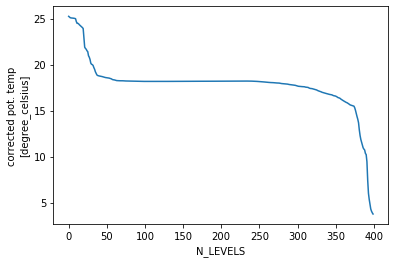

In [18]:
observation_temp.plot()

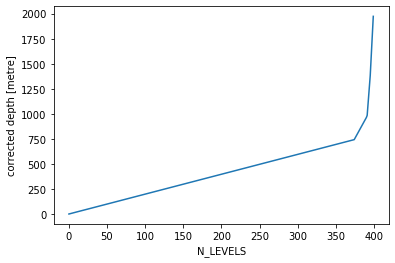

In [19]:
observation_dep.plot()

In [20]:
        model_level=np.zeros(int(dep_level[0]))
        model_dep=np.zeros(int(dep_level[0]))
        obsred_dep=np.zeros(int(dep_level[0]))
        obsred_temp=np.zeros(int(dep_level[0]))
        obsred_salt=np.zeros(int(dep_level[0]))
        for z in np.arange(int(dep_level[0])):
                obsred_dep[int(z)]=observation_dep[int(z)]
                obsred_temp[int(z)]=observation_temp[int(z)]
                obsred_salt[int(z)]=observation_salt[int(z)]
                diff_dep=0*depN.values
                for k in np.arange(len(depN.values)):
                        diff_dep[k]=depN.values[k]-obsred_dep[int(z)]
                lev=np.where(np.abs(diff_dep)==np.min(np.abs(diff_dep)))
                model_level[z]=lev[0]
                model_dep[z]=depN.values[lev[0]]


In [21]:
model_dep

array([   4.1873107 ,    5.73867321,    7.44886065,    9.31841755,
         11.34786892,   13.53772163,   15.88846016,   18.40055275,
         18.40055275,   21.07444382,   23.91056442,   26.90931511,
         26.90931511,   30.07108688,   30.07108688,   33.39624023,
         36.88512039,   36.88512039,   40.53804779,   40.53804779,
         44.35532761,   44.35532761,   48.33723831,   48.33723831,
         52.48403549,   52.48403549,   56.79595184,   56.79595184,
         61.27320862,   61.27320862,   61.27320862,   65.91599274,
         65.91599274,   70.72447968,   70.72447968,   75.69881439,
         75.69881439,   75.69881439,   80.83911133,   80.83911133,
         80.83911133,   86.14549255,   86.14549255,   91.6180191 ,
         91.6180191 ,   91.6180191 ,   97.25676727,   97.25676727,
         97.25676727,  103.06175232,  103.06175232,  103.06175232,
        109.03300476,  109.03300476,  109.03300476,  115.17050171,
        115.17050171,  115.17050171,  121.47422028,  121.47422

In [22]:
distance_threshold = 0.25
square_distance_to_observation = (lonN - observation_lon)**2 + (latN-observation_lat)**2


In [23]:
square_distance_to_observation.shape

(801, 1232)

In [24]:
dsN

<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, deptht: 300, time_counter: 475, x: 1232, y: 801)
Coordinates:
    nav_lat              (y, x) float32 dask.array<chunksize=(801, 1232), meta=np.ndarray>
    nav_lon              (y, x) float32 dask.array<chunksize=(801, 1232), meta=np.ndarray>
  * deptht               (deptht) float32 0.48045477 1.5587916 ... 6025.346
    time_centered        (time_counter) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter         (time_counter) float64 1.718e+09 ... 1.759e+09
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    deptht_bounds        (time_counter, deptht, axis_nbounds) float32 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    vosaline             (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 1, 801, 1232), meta=np.ndarray>
    votemper             (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 1, 801, 1232), meta=np.ndarray>
Attributes:
    description:       ocean T grid variables
    title:             ocean T grid variables
    Conventions:       CF-1.5
    production:        An IPSL model
    start_date:        20120301
    output_frequency:  1d
    CONFIG:            NATL60
    CASE:              CJM165
    history:           Wed Feb 12 15:04:57 2020: ncks -O -F -d x,1,1232 -d y,...
    NCO:               4.4.6

In [25]:
is_close_to_observation = square_distance_to_observation < distance_threshold**2


In [26]:
is_close_to_observation.shape

(801, 1232)

In [29]:
is_close_to_observation[0,0].values

array(False)

In [30]:
tempN

<xarray.DataArray 'votemper' (time_counter: 475, deptht: 300, y: 801, x: 1232)>
dask.array<concatenate, shape=(475, 300, 801, 1232), dtype=float32, chunksize=(1, 1, 801, 1232)>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(801, 1232), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(801, 1232), meta=np.ndarray>
  * deptht         (deptht) float32 0.48045477 1.5587916 ... 5974.8853 6025.346
    time_centered  (time_counter) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) float64 1.718e+09 1.718e+09 ... 1.759e+09
Dimensions without coordinates: y, x
Attributes:
    standard_name:     sea_water_potential_temperature
    long_name:         temperature
    units:             degC
    online_operation:  average
    interval_write:    1 d

In [32]:
one_month_around_obs = (timN.values < tsecen4 + 15*24*3600) & (timN.values > tsecen4 - 15*24*3600)
